In [1]:
import DoG_maps
import findPointSources_function as fpsrc

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
dirname_str_M0717="/users/ksarmien/Documents/clusters_substructure/diff_Gauss_img_map_M0717"
DoG_dict_M0717,Point_src_dict_M0717,coords_M0717,psrcs_M0717=fpsrc.kMeans_point_sources("M0717",dirname_str_M0717,4)
keys_M0717=DoG_dict_M0717.keys()
keys_M0717=list(keys_M0717)

In [10]:
psrcs_M0717[:,1],psrcs_M0717[:,0]

(array([320.97883598, 287.43874644, 289.82758621, 394.71428571]),
 array([253.22222222, 284.88888889, 361.94827586, 371.57142857]))

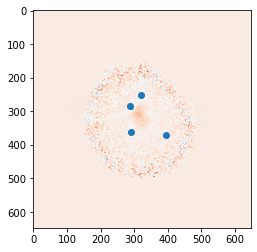

In [13]:
plt.imshow(DoG_dict_M0717[keys_M0717[15]],cmap="RdBu")
plt.scatter(psrcs_M0717[:,1],psrcs_M0717[:,0])

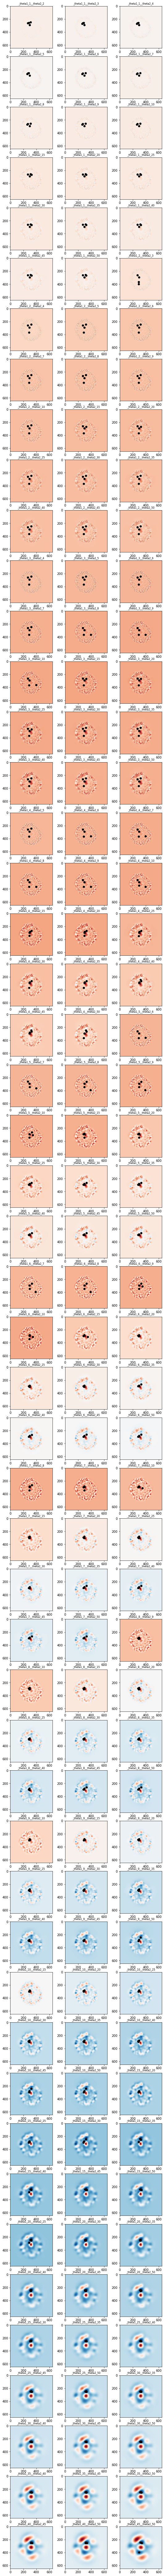

In [8]:
fig, axs = plt.subplots(51,3,figsize=(9,153))
count=0
for i in range(51):
    for j in range(3):
        axs[i,j].imshow(DoG_dict_M0717[keys_M0717[count]],cmap="RdBu")
        axs[i,j].set_title(keys_M0717[count],fontsize=8)
        axs[i,j].scatter(Point_src_dict_M0717[keys_M0717[count]][1],Point_src_dict_M0717[keys_M0717[count]][0],c='k')
        count+=1

In [210]:
def psrc_finder(dog_map,clustername):
    masked_map = fpsrc.maskByWeight(dog_map,clustername)
    max_mag = np.max(masked_map)
    current_std = np.std(masked_map.flatten())
    current_avg = np.mean(masked_map.flatten())
    rel_mag = max_mag/current_std
    pointsrc_coords_x=[]
    pointsrc_coords_y=[]
    center=np.where(masked_map==np.max(masked_map))
    pointsrc_coords_x=np.append(pointsrc_coords_x,center[0][0])
    pointsrc_coords_y=np.append(pointsrc_coords_y,center[1][0])
    xmin=center[0][0]-10
    xmax=center[0][0]+10
    ymin=center[1][0]-10
    ymax=center[1][0]+10
    masked_map[xmin:xmax,ymin:ymax]=0
    new_avg = np.mean(masked_map.flatten())
    new_std = np.std(masked_map.flatten())
    new_rel_mag = max_mag/new_std
    num_src = 1
    std_arr=[]
    std_arr=np.append(std_arr,new_std)
    source_mag = []
    source_mag = np.append(source_mag,max_mag)
    while num_src<10:
        max_mag = np.max(masked_map)
        current_std = np.std(masked_map.flatten())
        current_avg = np.mean(masked_map.flatten())
        rel_mag = max_mag/current_std
        center = np.where(masked_map==np.max(masked_map))
        pointsrc_coords_x=np.append(pointsrc_coords_x,center[0][0])
        pointsrc_coords_y=np.append(pointsrc_coords_y,center[1][0])
        xmin=center[0][0]-10
        xmax=center[0][0]+10
        ymin=center[1][0]-10
        ymax=center[1][0]+10
        masked_map[xmin:xmax,ymin:ymax]=0
        new_avg = np.mean(masked_map.flatten())
        new_std = np.std(masked_map.flatten())
        new_rel_mag = max_mag/new_std
        num_src+=1
        std_arr = np.append(std_arr,new_std)
        source_mag = np.append(source_mag,max_mag)
    src = np.arange(len(std_arr)-2)
    src = src[np.diff(np.diff(std_arr))>0]
    src = src[0]+2
    return src,pointsrc_coords_x[0:src],pointsrc_coords_y[0:src]

In [211]:
def all_Point_Srcs(clustername,dir_str):
    """"Takes in a cluster name (string), directory, number of sources (integer). Returns a dictionary of point sources of all DoG maps associated with cluster, and a dictionary of all the DoG maps."""
    DoG_diction={}
    filenames_arr=fpsrc.get_filenames(clustername)
    Point_src_diction={}
    num_src_arr = []
    for i in filenames_arr:
        full_name_str=dir_str+i
        array_data=np.loadtxt(full_name_str)
        DoG_diction[i]=array_data
        num_src,arr_ps_x,arr_ps_y=psrc_finder(array_data,clustername)
        Point_src_diction[i]=[arr_ps_x,arr_ps_y]
        num_src_arr = np.append(num_src_arr,num_src)
    return num_src_arr, DoG_diction,Point_src_diction

In [219]:
from sklearn.cluster import KMeans
from astropy.coordinates import SkyCoord
from astropy import wcs

In [222]:
def kMeans_point_sources(clustername,dir_str):
    """"Takes in a dictionary of point sources (keys are names for each DoG map, values are the pixel location of point sources) and returns the kmeans centers (point source location in )"""
    num_src_arr,DoG_diction,Point_src_diction = all_Point_Srcs(clustername,dir_str)
    num_centers = int(max(num_src_arr))
    keys=list(Point_src_diction.keys())
    X=[0,0]
    for i in range(len(keys)):
        arr_i=np.array(list(zip(Point_src_diction[keys[i]][0],Point_src_diction[keys[i]][1])))
        X=np.vstack((X,arr_i)) 
    X=X[1:]
    kmeans= KMeans(n_clusters=num_centers,random_state=0).fit(X)
    point_src_centers=kmeans.cluster_centers_
    ##############
    w=fpsrc.get_WCS_from_fits(clustername)
    coords_ra_dec=w.wcs_pix2world(point_src_centers,1)
    return DoG_diction,Point_src_diction,coords_ra_dec,point_src_centers

In [223]:
DoG_diction,Point_src_diction,coords_ra_dec,point_src_centers=kMeans_point_sources("M0717","/users/ksarmien/Documents/clusters_substructure/diff_Gauss_img_map_M0717")

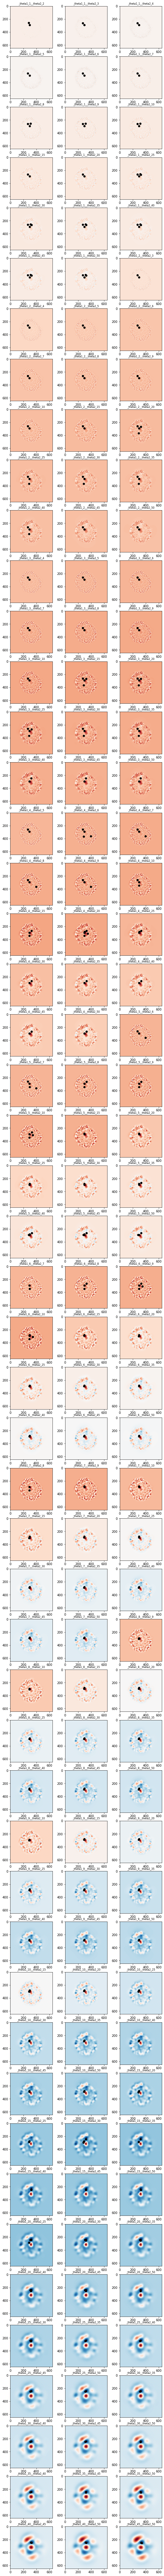

In [224]:
fig, axs = plt.subplots(51,3,figsize=(9,153))
count=0
for i in range(51):
    for j in range(3):
        axs[i,j].imshow(DoG_diction[keys_M0717[count]],cmap="RdBu")
        axs[i,j].set_title(keys_M0717[count],fontsize=8)
        axs[i,j].scatter(Point_src_diction[keys_M0717[count]][1],Point_src_diction[keys_M0717[count]][0],c='k')
        count+=1

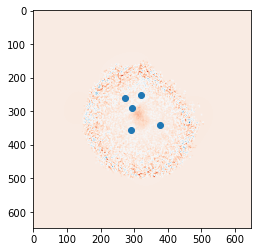

In [225]:
plt.imshow(DoG_diction[keys_M0717[15]],cmap="RdBu")
plt.scatter(point_src_centers[:,1],point_src_centers[:,0])

In [181]:
dog_map = np.loadtxt("/users/ksarmien/Documents/clusters_substructure/diff_Gauss_img_map_M0717_theta1_5__theta2_20")
num_src = psrc_finder(dog_map,"M0717")

In [182]:
num_src

2

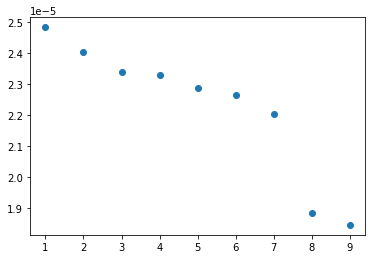

In [148]:
plt.scatter(np.arange(len(source_mag))[1:],source_mag[1:])

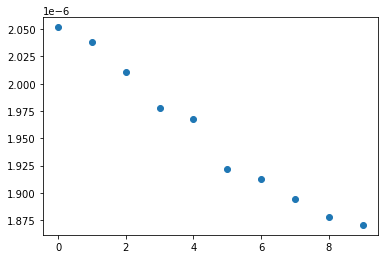

In [149]:
plt.scatter(np.arange(len(std_arr)),std_arr)

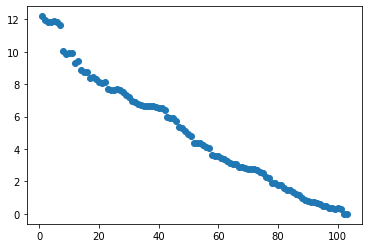

In [140]:
plt.scatter(np.arange(len(std_arr))[1:],(source_mag/std_arr)[1:])

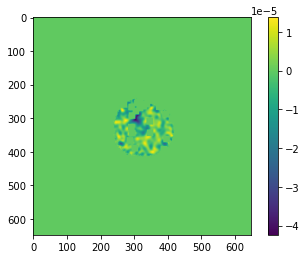

In [123]:
plt.imshow(masked_map)
plt.colorbar()

ValueError: x and y must be the same size

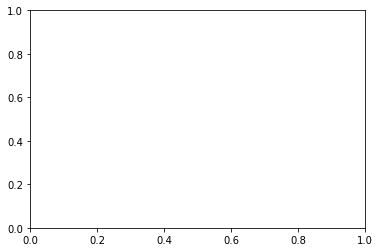

In [77]:
plt.scatter(np.arange(10),change)

In [ ]:
def getBackground(clustername,psrcs):
    hdu_map,img_map,weight_map=DoG_maps.load_Data(clustername)
    masked_map = fpsrc.maskByWeight(img_map,clustername)
    psrcs_x = psrcs[:,0]
    psrcs_y = psrcs[:,1]
    for i in range(len(psrcs_x)):
        masked_map[(int(psrcs_x[i])-20):(int(psrcs_x[i])+20),(int(psrcs_y[i])-20):(int(psrcs_y[i])+20)]= 0
    background_mean = np.mean(masked_map)
    psrcs_x_v2 = psrcs_x[1:]
    psrcs_y_v2 = psrcs_y[1:]
    for i in range(len(psrcs_x_v2)):
        img_map[(int(psrcs_x_v2[i])-20):(int(psrcs_x_v2[i])+20),(int(psrcs_y_v2[i])-20):(int(psrcs_y_v2[i])+20)]=background_mean
    return img_map

In [ ]:
plt.imshow(getBackground("MOO1506",psrcs_MOO1506))

In [14]:
dirname_str_MOO1506="/users/ksarmien/Documents/clusters_substructure/diff_Gauss_img_map_MOO1506"
DoG_dict_MOO1506,Point_src_dict_MOO1506,coords_MOO1506,psrcs_MOO1506=fpsrc.kMeans_point_sources("MOO1506",dirname_str_MOO1506,4)
keys_MOO1506=DoG_dict_MOO1506.keys()
keys_MOO1506=list(keys_MOO1506)

In [ ]:
dirname_str_MOO1506="/users/ksarmien/Documents/clusters_substructure/diff_Gauss_img_map_MOO1506"
DoG_dict_MOO1506,Point_src_dict_MOO1506,coords_MOO1506,psrcs_MOO1506=fpsrc.kMeans_point_sources("MOO1506",dirname_str_MOO1506,4,mask=True,mask_rad=250)
keys_MOO1506=DoG_dict_MOO1506.keys()
keys_MOO1506=list(keys_MOO1506)

In [ ]:
plt.imshow(DoG_dict_M0717[keys_M0717[30]],cmap="RdBu")
plt.scatter(psrcs_M0717[:,1],psrcs_M0717[:,0],c="k")

In [ ]:
plt.imshow(DoG_dict_MOO1506[keys_MOO1506[30]],cmap="RdBu")
plt.scatter(psrcs_MOO1506[:,1],psrcs_MOO1506[:,0],c="k")

In [ ]:
theta1=[1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
theta2=[1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
MOO1142=DoG_maps.DoG_loop("MOO1142",theta1,theta2)

In [ ]:
np.